In [2]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import thinkbayes2 as tb
from highlight_text import fig_text
import matplotlib.ticker as ticker


In [3]:
pbp_df = pd.concat([pd.read_csv(f"/Users/max/Downloads/nhl_pbp{season}.csv.gz", compression="gzip")for season in [20212022]],  ignore_index=True)
pbp_df.columns = pbp_df.columns.str.lower()

pbp_df.sample(5)

,game_id,date,period,event,description,time_elapsed,seconds_elapsed,strength,ev_zone,type,...,away_score,home_score,away_goalie,away_goalie_id,home_goalie,home_goalie_id,xc,yc,home_coach,away_coach
434145,30315,2022-06-09,2,GIVE,"TBL GIVEAWAY - #24 BOGOSIAN, Def. Zone",10:21,621.0,5x5,Def,NaN,...,0,0,ANDREI VASILEVSKIY,8476883.0,IGOR SHESTERKIN,8478048.0,35.0,39.0,Gerard Gallant,Jon Cooper
157192,20591,2022-01-04,2,SHOT,"CHI ONGOAL - #17 STROME, Wrist, Off. Zone, 34 ft.",17:32,1052.0,5x5,Off,WRIST SHOT,...,2,1,DARCY KUEMPER,8475311.0,MARC-ANDRE FLEURY,8470594.0,62.0,-22.0,Derek King,Jared Bednar
426154,30242,2022-05-20,2,HIT,"EDM #37 FOEGELE HIT CGY #44 GUDBRANSON, Def. Zone",7:10,430.0,5x5,Def,NaN,...,2,3,MIKE SMITH,8469608.0,JACOB MARKSTROM,8474593.0,50.0,-41.0,Darryl Sutter,Jay Woodcroft
220414,20664,2022-02-08,1,BLOCK,"EDM #84 LAGESSON BLOCKED BY VGK #71 KARLSSON,...",1:20,80.0,5x5,Def,WRIST SHOT,...,0,0,LAURENT BROSSOIT,8476316.0,MIKE SMITH,8469608.0,41.0,21.0,Dave Tippett,Peter DeBoer
74707,20246,2021-11-17,2,FAC,SEA won Neu. Zone - CHI #77 DACH vs SEA #67 GE...,2:01,121.0,5x5,Neu,NaN,...,2,0,MARC-ANDRE FLEURY,8470594.0,PHILIPP GRUBAUER,8475831.0,0.0,0.0,Dave Hakstol,Derek King


In [4]:
pd.options.mode.chained_assignment = None  # default='warn' -> Stops it from giving me some error

def fixed_seconds_elapsed(pbp_df):
    '''
    This function fixes the seconds elapsed column to tally the total seconds
    elapsed for the whole game instead of just seconds elapsed for the period
    Inputs:
    pbp_df - pbp_df without seconds_elapsed fixed
    Outputs:
    pbp_df - pbp_df with seconds_elapsed correctly calculated
    '''

    pbp_df.loc[:, 'seconds_elapsed'] = pbp_df.loc[:, 'seconds_elapsed'] + (1200 * (pbp_df.period -1))

    return pbp_df

def switch_block_shots(pbp_df):
    '''
    This function switches the p1 and p2 of blocked shots because Harry's
    scraper lists p1 as the blocker instead of the shooter
    Inputs:
    pbp_df - dataframe of play by play to be cleaned
    Outputs:
    pbp_df - cleaned dataframe
    '''

#creating new columns where I switch the players around for blocked shots
    pbp_df.loc[:, ('new_p1_name')] = np.where(pbp_df.event == 'BLOCK',
                                              pbp_df.p2_name, pbp_df.p1_name)
    pbp_df.loc[:, ('new_p2_name')] = np.where(pbp_df.event == 'BLOCK',
                                              pbp_df.p1_name, pbp_df.p2_name)
    pbp_df.loc[:, ('new_p1_id')] = np.where(pbp_df.event == 'BLOCK',
                                            pbp_df.p2_id, pbp_df.p1_id)
    pbp_df.loc[:, ('new_p2_id')] = np.where(pbp_df.event == 'BLOCK',
                                            pbp_df.p1_id, pbp_df.p2_id)

#saving the new columns as the old ones
    pbp_df.loc[:, ('p1_name')] = pbp_df['new_p1_name']
    pbp_df.loc[:, ('p2_name')] = pbp_df['new_p2_name']
    pbp_df.loc[:, ('p1_id')] = pbp_df['new_p1_id']
    pbp_df.loc[:, ('p2_id')] = pbp_df['new_p2_id']

#drop unused new columns
    pbp_df = pbp_df.drop(['new_p1_name', 'new_p2_name',
                          'new_p1_id', 'new_p2_id'], axis=1)

    return pbp_df

def calc_distance(pbp_df):
    '''
    This function calculates the distance from the coordinate given for the
    event to the center of the goal
    Input:
    pbp_df - play by play dataframe
    Output:
    pbp_df - play by play dataframe with distance calculated
    '''
    pbp_df.loc[:, ('distance')] = np.sqrt((87.95-abs(pbp_df.xc_adj))**2
                                          + pbp_df.yc_adj**2)

    return pbp_df

def calc_angle(pbp_df):
    '''
    This function calculates the angle of the shooter from center ice with the
    vertex of the angle being located at the center of the goal
    Input:
    pbp_df - play by play dataframe
    Output:
    pbp_df - play by play dataframe with shooter angle calculated
    '''

    pbp_df.loc[:, ('angle')] = (np.arcsin(abs(pbp_df.yc_adj)/np.sqrt((87.95-abs(pbp_df.xc_adj))**2 + pbp_df.yc_adj**2)) * 180) / 3.14

    pbp_df.loc[:, ('angle')] = np.where((pbp_df.xc_adj > 88) | (pbp_df.xc_adj < -88), 90 + (180-(90 + pbp_df.angle)), pbp_df.angle)

    return pbp_df

def calc_time_diff(pbp_df):
    '''
    This function calculates the time difference between events
    Input:
    pbp_df - play by play dataframe
    Output:
    pbp_df - play by play dataframe with time difference calculated
    '''

    pbp_df.loc[:, ('time_diff')] = pbp_df.seconds_elapsed - pbp_df.seconds_elapsed.shift(1)

    return pbp_df

def calc_event_length(pbp_df):
    '''
    This function calculates the time difference between events
    Input:
    pbp_df - play by play dataframe
    Output:
    pbp_df - play by play dataframe with time difference calculated
    '''

    pbp_df.loc[:, ('event_length')] = pbp_df.seconds_elapsed.shift(-1) - pbp_df.seconds_elapsed

    return pbp_df

def calc_rebound(pbp_df):
    '''
    This function calculates whether the corsi event was generated off of a
    goalie rebound by looking at the time difference between the current event
    and the last event and checking that last even was a shot as well
    Input:
    pbp_df - play by play dataframe
    Output:
    pbp_df - play by play dataframe with rebound calculated
    '''

    pbp_df.loc[:, ('is_rebound')] = np.where((pbp_df.time_diff < 4) &
                                             ((pbp_df.event.isin(['SHOT', 'GOAL'])) &
                                              (pbp_df.event.shift(1) == 'SHOT') &
                                              (pbp_df.ev_team == pbp_df.ev_team.shift(1))),
                                             1, 0)

    return pbp_df

def calc_rush_shot(pbp_df):
    '''
    This function calculates whether the corsi event was generated off the rush
    by looking at the time difference between the last even and whether the last
    event occured in the neutral zone
    Input:
    pbp_df - play by play dataframe
    Output:
    pbp_df - play by play dataframe with is_rush calculated
    '''

    pbp_df.loc[:, ('is_rush')] = np.where((pbp_df.time_diff < 4) &
                                          (pbp_df.event.isin(['SHOT', 'MISS', 'BLOCK', 'GOAL'])) &
                                          (abs(pbp_df.xc.shift(1)) < 26),
                                          1, 0)

    return pbp_df

def calc_prior_coords(pbp_df):
    '''
    this function calculates the coordiantes of the preceeding event and then
    the distance from the
    '''

    pbp_df['prior_x_coords'] = pbp_df['xc_adj'].shift(1)
    pbp_df['prior_y_coords'] = pbp_df['yc_adj'].shift(1)

    pbp_df['prior_x_coords'] = pbp_df['prior_x_coords'].fillna(0)
    pbp_df['prior_y_coords'] = pbp_df['prior_y_coords'].fillna(0)

    return pbp_df

def calc_prior_distance(pbp_df):
    '''
    this function calculates the distance from the current event to the
    event prior
    '''
    pbp_df['dist_to_prior'] = np.sqrt(((pbp_df['xc_adj'] - pbp_df['prior_x_coords'])**2 + (pbp_df['yc_adj'] - pbp_df['prior_y_coords'])**2))

    return pbp_df

def calc_shooter_strength(pbp_df):
    '''
    Function calculates the team strength of the shooter such as 5v5, 5v4,
    etc. This is done by subtracting the home and away skaters based on who is
    shooting the puck.
    Input:
    pbp_df - play by play dataframe
    Output:
    pbp_df - play by play dataframe with shooter strength calculated
    '''

#calculates shooter strength based on who's shooting
    pbp_df.loc[:, ('shooter_strength')] = \
            np.where((pbp_df.ev_team == pbp_df.home_team),
                     pbp_df.home_players - pbp_df.away_players,
                     pbp_df.away_players - pbp_df.home_players)

#handle empty net situations this time for the home team
    pbp_df.loc[:, ('shooter_strength')] = \
            np.where((pbp_df.ev_team == pbp_df.home_team) &
                     (pbp_df.home_goalie.isnull()),
                     pbp_df['shooter_strength'] + 1,
                     pbp_df['shooter_strength'])

#away team empty net situations
    pbp_df.loc[:, ('shooter_strength')] = \
            np.where((pbp_df.ev_team == pbp_df.away_team) &
                     (pbp_df.away_goalie.isnull()),
                     pbp_df['shooter_strength'] + 1,
                     pbp_df['shooter_strength'])

    return pbp_df

def calc_rebound_angle(pbp_df):
    '''
    Function calculates the angle between two shots if the second shot
    is flagged as a rebound else the value is zero
    Input:
    pbp_df - play by play dataframe
    Output:
    pbp_df - play by play dataframe
    '''
    pbp_df.loc[:, ('rebound_angle')] = \
            np.where(pbp_df.is_rebound == 1,
                     pbp_df.angle + pbp_df.angle.shift(1), 0)

    return pbp_df

def calc_shot_metrics(pbp_df):
    '''
    function to calculate whether an event is a corsi or fenwick event
    Inputs:
    pbp_df - play by play dataframe
    Outputs:
    pbp_df - play by play dataframe with corsi and fenwick columns calculated
    '''

    corsi = ['SHOT', 'BLOCK', 'MISS', 'GOAL']
    fenwick = ['SHOT', 'MISS', 'GOAL']
    shot = ['SHOT', 'GOAL']

    pbp_df.loc[:, ('is_corsi')] = np.where(pbp_df.event.isin(corsi), 1, 0)
    pbp_df.loc[:, ('is_fenwick')] = np.where(pbp_df.event.isin(fenwick), 1, 0)
    pbp_df.loc[:, ('is_shot')] = np.where(pbp_df.event.isin(shot), 1, 0)
    pbp_df.loc[:, ('is_goal')] = np.where(pbp_df.event == 'GOAL', 1, 0)

    return pbp_df

def calc_is_home(pbp_df):
    '''
    Function determines whether event was taken by the home team or not
    Inputs:
    pbp_df - play by play dataframe
    Outputs:
    pbp_df - play by play dataframe
    '''

    pbp_df.loc[:, ('is_home')] = np.where(pbp_df.ev_team == pbp_df.home_team,
                                          1, 0)

    return pbp_df

def calc_score_diff(pbp_df):
    '''
    Function to calculate score differential for score adjustment caps at
    +/- 3 due to Micah Blake McCurdy's (@Ineffectivemath on Twitter) adjustment
    method.
    Input:
    pbp_df - play by play df
    Output:
    pbp_df - play by play df with score diff calculated
    '''

    pbp_df.loc[:, ('score_diff')] = pbp_df.home_score - pbp_df.away_score

    pbp_df.loc[:, ('score_diff')] = np.where(pbp_df.score_diff < -3, -3,
                                             pbp_df.score_diff)

    pbp_df.loc[:, ('score_diff')] = np.where(pbp_df.score_diff > 3, 3,
                                             pbp_df.score_diff)

    return pbp_df

def calc_is_hit(pbp_df):
    '''
    determines whether event is a hit or not
    Input:
    pbp_df - play by play df
    Output:
    pbp_df - play by play df with is_hit column calculated
    '''
    pbp_df['is_hit'] = np.where(pbp_df.event == 'HIT', 1, 0)

    return pbp_df

def calc_is_penalty(pbp_df):
    '''
    calculates whether an event is a penalty
    Input:
    pbp_df - play by play df
    Output:
    pbp_df - play by play df with is_penalty column created
    '''

    pbp_df.loc[:, 'is_penalty'] = np.where((pbp_df.event == 'PENL'), 1, 0)
    pbp_df.loc[:, 'is_penalty'] = np.where((pbp_df.event == 'PENL') &
                                    (pbp_df.description.str.contains('fighting', regex=False, case=False)), 0, pbp_df.is_penalty)
    pbp_df.loc[:, 'is_penalty'] = np.where((pbp_df.event == 'PENL') &
                                    (pbp_df.description.str.contains('maj', regex=False, case=False)), 0, pbp_df.is_penalty)
    pbp_df.loc[:, 'is_penalty'] = np.where((pbp_df.event == 'PENL') &
                                    (pbp_df.description.str.contains('misconduct', regex=False, case=False)), 0, pbp_df.is_penalty)
    pbp_df.loc[:, 'is_penalty'] = np.where((pbp_df.event == 'PENL') &
                                    (pbp_df.description.str.\
                                           contains('double minor',
                                                    case=False)),
                                    2, pbp_df.is_penalty)

    return pbp_df

def calc_is_goal(pbp_df):
    '''
    determines whether an event is a goal or not
    '''
    pbp_df['is_goal'] = np.where(pbp_df.event == 'GOAL', 1, 0)

    return pbp_df

def calc_season(pbp_df):
    '''
    this function calculates the season from the date of the game
    Inputs:
    pbp_df - pbp_df without a season column
    Outputs - pbp_df with the season of the game calculated
    '''


    pbp_df.loc[:, ('season')] = np.where(pbp_df.date.dt.month.isin([10, 11, 12]),
                                        pbp_df.date.dt.year + 1, pbp_df.date.dt.year)
    return pbp_df

def fix_game_id(pbp_df):
    '''
    this fixes the game_id by putting it in the format that the NHL uses
    Input:
    pbp_df - pbp_df with out game_id fixed
    Output:
    pbp_df - pbp_df with game_id fixed
    '''

    new_season = pbp_df['season'] - 1
    pbp_df.loc[:, ('game_id')] =  new_season.map(str)+ '0' + pbp_df['game_id'].map(str)
    pbp_df.loc[:, ('game_id')] = pbp_df.loc[:, ('game_id')].astype(float).astype(int)

    return pbp_df



class RinkAdjust(object):
    
    def __init__(self):
        self.teamxcdf, self.teamycdf, self.otherxcdf, self.otherycdf = {}, {}, {}, {}

    def addCDFs(self, team, this_x_cdf, this_y_cdf, other_x_cdf, other_y_cdf):
        self.teamxcdf[team] = this_x_cdf        
        self.teamycdf[team] = this_y_cdf        
        self.otherxcdf[team] = other_x_cdf        
        self.otherycdf[team] = other_y_cdf

    def addTeam(self, team, this_team, rest_of_league):
        this_x_cdf = tb.MakeCdfFromPmf(tb.MakePmfFromList(this_team.xc))
        this_y_cdf = tb.MakeCdfFromPmf(tb.MakePmfFromList(this_team.yc))
        other_x_cdf = tb.MakeCdfFromPmf(tb.MakePmfFromList(rest_of_league.xc))
        other_y_cdf = tb.MakeCdfFromPmf(tb.MakePmfFromList(rest_of_league.yc))
        self.addCDFs(team, this_x_cdf, this_y_cdf, other_x_cdf, other_y_cdf)

    def PlotTeamCDFs(self, team, savefig=False):
        this_x_cdf = self.teamxcdf[team]
        this_y_cdf = self.teamycdf[team]
        other_x_cdf = self.otherxcdf[team]        
        other_y_cdf = self.otherycdf[team]

        f, axx = plt.subplots(1, 2, sharey='col')
        f.set_size_inches(14, 8)
    
        xx1, yx1 = this_x_cdf.Render()
        xx2, yx2 = other_x_cdf.Render()

        axx[0].plot(xx1, yx1, color='blue', label='@%s' % team)
        axx[0].plot(xx2, yx2, color='brown', label='@Rest of League')
        axx[0].set_xlabel('CDF of X')
        axx[0].legend()
    
        xy1, yy1 = this_y_cdf.Render()
        xy2, yy2 = other_y_cdf.Render()
    
        axx[1].plot(xy1, yy1, color='blue', label='@%s' % team)
        axx[1].plot(xy2, yy2, color='brown', label='@Rest of League')
        axx[1].set_xlabel('CDF of Y')
        axx[1].legend()
    
        f.suptitle('Cumulative Density Function for Shot Location Rink Bias Adjustment')
        
        plt.show()
        
        if savefig:
            #f.set_tight_layout( True )
            plt.savefig('Rink bias CDF chart %s.png' % team)


    def rink_bias_adjust( self, x, y, team ):
        """ this method implements the actual location conversion from biased to "unbiased" shot location
        
         the way it works for rink bias adjustment is that for a given shot location in a specific rink,
         you find the cumulative probabilities for that x and y in that rink. Then you calculate the league 
         equivalent x and y that have the same probabilities as the one measured in the specific rink
         
         The equivalency CDFs are calculated using only visiting teams, which ensures that both single rink and
         league wide rinks have as wide a sample of teams as possible but avoid any possible home team bias.
         All of which lets us assume that they are then unbiased enough to be representative (at least enough 
         for standardization purposes)
         
         This is (my adaption of my understanding of) Shuckers' method for rink bias adjustment as described in Appendix A here:
         http://www.sloansportsconference.com/wp-content/uploads/2013/Total%20Hockey%20Rating%20(THoR)%20A%20comprehensive%20statistical%20rating%20of%20National%20Hockey%20League%20forwards%20and%20defensemen%20based%20upon%20all%20on-ice%20events.pdf
    
         for example, if a shot x coordinate is measured as xmeas in a rink
         
             xprob = this_x_cdf.Prob( xmeas )  # cum prob of seeing xmeas in this rink
             xadj = other_x_cdf.Value( xprob ) # value associated with same prob in rest of league        
    
        analogous process for y
        
        The code for Cdf/Pmf creation and manipulation is taken directly from Allan Downey's code for "Think Bayes"
        """
         
        xprob = self.teamxcdf[team].Prob(x)
        newx = self.otherxcdf[team].Value(xprob)
        
        yprob = self.teamycdf[team].Prob(y)
        newy = self.otherycdf[team].Value(yprob)
        
        return newx, newy
    
def fix_df(df):
    """
    Fixes df so it can be processed for rink adjustments
    
    :param df: Full DataFrame
    
    :return: Fixed DataFrame
    """
    # Only take events we need
    pbp_df = df.loc[df.event.isin(["SHOT", "GOAL", "MISS"])]

    pbp_df.xc = pbp_df.xc.astype(float)
    pbp_df.yc = pbp_df.yc.astype(float)

    # add a 'Direction' column to indicate the primary direction for shots. The heuristic to determine
    # direction is the sign of the median of the X coordinate of shots in each period. This then lets us filter
    # out shots that originate from back in the defensive zone when the signs don't match
    gp_groups = pbp_df.groupby(by=['date', 'game_id', 'period'])['xc', 'yc']
    meanies = gp_groups.transform(np.median)  # will give us game/period median for X and Y for every data point
    pbp_df['Direction'] = np.sign(meanies['xc'])

    # should actually write this to a CSV as up to here is the performance intensive part
    pbp_df['xc'], pbp_df['yc'] = zip(*pbp_df.apply(lambda x: (x.xc, x.yc) if x.xc > 0 else (-x.xc, -x.yc), axis=1))

    return pbp_df


def create_cdfs(shots_df, rink_adjuster):
    """
    Goes through and creates cdf for each team
    
    :param shots_df: df with only - Goals, SOG, and Misses
    :param rink_adjuster: RinkAdjust object
    :return: None
    """
    # Now rip through each team and create a CDF for that team and for the other 29 teams in the league
    # For each home rink
    for team in sorted(shots_df.home_team.unique()):
        # Split shots into team arena and all other rinks
        shot_data = shots_df
        rink_shots = shot_data[shot_data.home_team == team]
        rest_of_league = shot_data[shot_data.home_team != team]

        # Create teamxcdf and otherxcdf for rink adjustment
        rink_adjuster.addTeam(team, rink_shots, rest_of_league)


def adjust_play(play, rink_adjuster):
    """
    Apply rink adjustments to play
    
    :param play: given play in game
    :param rink_adjuster: RinkAdjust object
    
    :return: newx, newy
    """
    if play['event'] in ["SHOT", "GOAL", "MISS"]:
        # abs() for xC because all coordinates are made positive for cdf (to make it normal)
        newx, newy = rink_adjuster.rink_bias_adjust(abs(play['xc']), play['yc'], play['home_team'])

        # if xC is really negative (because cdf only deals in positives) change it back
        newx = -newx if play['xc'] < 0 else newx
    else:
        newx, newy = play['xc'], play['yc']

    return newx, newy


def adjust_df(pbp_df, rink_adjuster):
    """
    Apply rink adjustments to PBP. Iterates through every play and adjusts from there
    
    :param pbp_df: PBP DataFrame
    :param rink_adjuster: RinkAdjust object
    
    :return: Adjusted DataFrame
    """
    df_dict = pbp_df.to_dict('records')

    pbp_df['xc_adj'], pbp_df['yc_adj'] = map(list, zip(*[adjust_play(row, rink_adjuster) for row in df_dict]))

    return pbp_df


def adjust(df):
    """
    Take a DataFrame and:
    1. Creates CDF's for each team
    2. Adjusts given games
    
    **Note: I advise not feeding this a DataFrame with less than one year's worth of data
    
    :param df: DataFrame of games
    
    :return: DataFrame with distance Rink Adjusted
    """
    rink_adjuster = RinkAdjust()

    # Make sure coords columns aren't string
    df['xc'] = df['xc'].astype(float)
    df['yc'] = df['yc'].astype(float)

    create_cdfs(fix_df(df), rink_adjuster)
    pbp_df = adjust_df(df, rink_adjuster)

    return pbp_df

def remove_so(pbp_df):
    pbp_df = pbp_df.drop(pbp_df[(pbp_df.period == 5)
                                & (pbp_df.seconds_elapsed == 0) \
                                & (~pbp_df.strength.isin(['5x5', '5x4'])) \
                                & (pbp_df.event.isin(["GOAL", "SHOT", "MISS"]))].index)
    return pbp_df
    

def calc_xg(pbp_df):
    '''
    this function calculates the xg value of each shot, miss or block and then
    joins it back to the main pbp_df
    Inputs:
    pbp_df - play by play data frame without xg calculations made
    Outputs:
    pbp_df_xg - play by play data frame with xg probabilities calculated
    '''
    
    if 'xc_adj' not in pbp_df.columns:
        pbp_df = adjust(pbp_df) 
    
    breezy = joblib.load('log_model')

    feature_columns = ['seconds_elapsed', 'xc_adj', 'yc_adj', 'time_diff', 'score_diff',
                       'prior_x_coords', 'prior_y_coords', 'dist_to_prior',
                       'distance', 'angle', 'is_rebound', 'rebound_angle',
                       'is_rush', 'shooter_strength', 'type_BACKHAND',
                       'type_DEFLECTED', 'type_SLAP SHOT', 'type_SNAP SHOT',
                       'type_TIP-IN', 'type_WRIST SHOT']

    fenwick_pbp = pd.get_dummies(pbp_df[pbp_df.event.isin(['SHOT', 'GOAL', 'MISS'])],
                                     columns=['type'])

    for column in feature_columns:
        if column not in fenwick_pbp.columns:
            fenwick_pbp[column] = 0

    fenwick_pbp_nona = fenwick_pbp[~fenwick_pbp[feature_columns].isnull().any(axis=1)]

    fenwick_pbp_nona['xg'] = breezy.predict_proba(fenwick_pbp_nona[feature_columns])[:, 1]

    fenwick_pbp = fenwick_pbp.merge(fenwick_pbp_nona[['xg']], how = 'outer', left_index=True, right_index=True)

    fenwick_pbp['xg'] = fenwick_pbp['xg'].fillna(fenwick_pbp['xg'].mean())

    pbp_df_xg = pbp_df.merge(fenwick_pbp[['xg']], how='outer',left_index=True, right_index=True)

    pbp_df_xg['xg'] = pbp_df_xg['xg'].fillna(0)
    
    pbp_df_xg['xg'] = np.where(((pbp_df_xg.period == 5)
                                & (pbp_df_xg.seconds_elapsed == 0) \
                                & (~pbp_df.strength.isin(['5x5', '5x4']))),0, pbp_df_xg['xg']) 

    return pbp_df_xg


def create_stat_features(pbp_df):
    '''
    this function cleans the pbp_df and casts columns as the proper variable
    type and calculates all the neccesary columns needed to calculate xG, on
    ice stats, and individual stats
    Input:
    pbp_df - uncleaned pbp_df
    Output:
    pbp_df - pbp dataframe cleaned and ready for further processing
    '''
    
    pbp_df = adjust(pbp_df) 
    pbp_df.loc[:, ('date')] = pbp_df.date.astype('datetime64[ns]')
    pbp_df = switch_block_shots(pbp_df)
    pbp_df = calc_time_diff(pbp_df)
    pbp_df = calc_event_length(pbp_df)
    pbp_df = calc_shot_metrics(pbp_df)
    pbp_df = calc_season(pbp_df)
    pbp_df = fix_game_id(pbp_df)
    pbp_df = calc_score_diff(pbp_df)
    pbp_df = calc_is_home(pbp_df)
    pbp_df = calc_is_penalty(pbp_df)
    pbp_df = calc_is_hit(pbp_df)
    pbp_df = calc_prior_coords(pbp_df)
    pbp_df = calc_prior_distance(pbp_df)
    pbp_df = calc_is_goal(pbp_df)
    pbp_df = calc_distance(pbp_df)
    pbp_df = calc_angle(pbp_df)
    pbp_df = calc_rebound(pbp_df)
    pbp_df = calc_rebound_angle(pbp_df)
    pbp_df = calc_rush_shot(pbp_df)
    pbp_df = calc_shooter_strength(pbp_df)
    #pbp_df = remove_so(pbp_df)
    pbp_df = calc_xg(pbp_df)

    return pbp_df


df = create_stat_features(pbp_df)

df.sample(5)

/var/folders/8b/dctd609n4zsgx5052t61l01c0000gn/T/ipykernel_30593/2155556476.py:444: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gp_groups = pbp_df.groupby(by=['date', 'game_id', 'period'])['xc', 'yc']
/Users/max/opt/anaconda3/lib/python3.9/site-packages/thinkbayes2/thinkbayes2.py:160: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
/Users/max/opt/anaconda3/lib/python3.9/site-packages/thinkbayes2/thinkbayes2.py:160: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
/Users/max/opt/anaconda3/lib/python3.9/site-packages/thinkbayes2/thinkbayes2.py:160: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
/Users/max/opt/an

,game_id,date,period,event,description,time_elapsed,seconds_elapsed,strength,ev_zone,type,...,prior_x_coords,prior_y_coords,dist_to_prior,distance,angle,is_rebound,rebound_angle,is_rush,shooter_strength,xg
425155,2021030212,2022-05-19,2,SHOT,"FLA ONGOAL - #62 MONTOUR, Snap, Off. Zone, 16 ft.",13:29,809.0,5x5,Off,SNAP SHOT,...,-56.0,-9.0,141.127602,15.287331,78.913831,0,0.0,0,0,0.103081
344597,2021021121,2022-04-05,1,HIT,"DAL #24 HINTZ HIT NYI #44 PAGEAU, Off. Zone",6:10,370.0,5x5,Off,NaN,...,20.0,22.0,122.576507,30.154643,95.762420,0,0.0,0,0,0.000000
3514,2021020011,2021-10-14,3,SHOT,"NYR ONGOAL - #93 ZIBANEJAD, Wrist, Off. Zone, ...",9:56,596.0,5x5,Off,WRIST SHOT,...,2.0,39.0,92.200868,22.592089,45.112535,0,0.0,0,0,0.060477
288024,2021020940,2022-03-12,2,MISS,"EDM #75 BOUCHARD, Wrist, Wide of Net, Off. Zon...",5:30,330.0,5x5,Off,WRIST SHOT,...,54.0,3.0,121.276543,34.620839,46.252280,0,0.0,0,0,0.039403
424285,2021030221,2022-05-18,1,SHOT,"NYR ONGOAL - #17 ROONEY, Wrist, Off. Zone, 38 ft.",9:53,593.0,5x5,Off,WRIST SHOT,...,-68.0,-32.0,139.003597,35.331325,61.362408,0,0.0,0,0,0.034565


In [7]:
df.columns

Index(['game_id', 'date', 'period', 'event', 'description', 'time_elapsed',
       'seconds_elapsed', 'strength', 'ev_zone', 'type', 'ev_team',
       'home_zone', 'away_team', 'home_team', 'p1_name', 'p1_id', 'p2_name',
       'p2_id', 'p3_name', 'p3_id', 'awayplayer1', 'awayplayer1_id',
       'awayplayer2', 'awayplayer2_id', 'awayplayer3', 'awayplayer3_id',
       'awayplayer4', 'awayplayer4_id', 'awayplayer5', 'awayplayer5_id',
       'awayplayer6', 'awayplayer6_id', 'homeplayer1', 'homeplayer1_id',
       'homeplayer2', 'homeplayer2_id', 'homeplayer3', 'homeplayer3_id',
       'homeplayer4', 'homeplayer4_id', 'homeplayer5', 'homeplayer5_id',
       'homeplayer6', 'homeplayer6_id', 'away_players', 'home_players',
       'away_score', 'home_score', 'away_goalie', 'away_goalie_id',
       'home_goalie', 'home_goalie_id', 'xc', 'yc', 'home_coach', 'away_coach',
       'unnamed: 0', 'xc_adj', 'yc_adj', 'time_diff', 'event_length',
       'is_corsi', 'is_fenwick', 'is_shot', 'is_goal', 

In [5]:
def get_df(df):
    
    games_dic_list = []
    #Make a df for the game
    for gameid in df.game_id.unique():
        game_df = df[(df.game_id == gameid) & (df.event.isin(["SHOT", "MISS", "GOAL"]))].reset_index(drop=True)
        
        game_dic = {"game_id" : gameid,
                    "date" : game_df.date.iloc[0],
                    "season" : game_df.season.iloc[0],
                    "home_team" : game_df.home_team.iloc[0],
                    "away_team" : game_df.away_team.iloc[0],
                    "home_xG" : game_df[game_df.is_home == 1].xg.sum(),
                    "away_xG" : game_df[game_df.is_home == 0].xg.sum()
        }
        games_dic_list.append(game_dic)
    
    new_df = pd.DataFrame(games_dic_list)
    return new_df



ok = get_df(df[(df.date > '2021-10-11') & (df.date < '2022-05-02')])

ok.head()
        

,game_id,date,season,home_team,away_team,home_xG,away_xG
0,2021020001,2021-10-12,2022,T.B,PIT,2.310559,2.923543
1,2021020002,2021-10-12,2022,VGK,SEA,3.395397,2.987696
2,2021020003,2021-10-13,2022,TOR,MTL,4.127679,2.611831
3,2021020004,2021-10-13,2022,WSH,NYR,2.409224,2.428459
4,2021020015,2021-10-13,2022,ANA,WPG,2.723489,3.219621


In [6]:
ok["W_team"] = np.where(ok.home_xG>ok.away_xG, ok.home_team, ok.away_team)

ok.head()

,game_id,date,season,home_team,away_team,home_xG,away_xG,W_team
0,2021020001,2021-10-12,2022,T.B,PIT,2.310559,2.923543,PIT
1,2021020002,2021-10-12,2022,VGK,SEA,3.395397,2.987696,VGK
2,2021020003,2021-10-13,2022,TOR,MTL,4.127679,2.611831,TOR
3,2021020004,2021-10-13,2022,WSH,NYR,2.409224,2.428459,NYR
4,2021020015,2021-10-13,2022,ANA,WPG,2.723489,3.219621,WPG


In [7]:
xlol = pd.DataFrame(ok.W_team.value_counts()).reset_index()
xlol= xlol.sort_values(by="index")
xlol.head()

,index,W_team
29,ANA,24
31,ARI,16
0,BOS,61
26,BUF,28
5,CAR,54


In [8]:
stan = pd.read_csv("stand.csv")
stan = stan[["Team", "W"]]

lgs = ["/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/ANA.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/ARZ.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/BOS.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/BUF.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/CAR.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/CBJ.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/CGY.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/CHI.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/COL.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/DAL.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/DET.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/EDM.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/FLO.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/LAK.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/MIN.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/MON.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/NJD.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/NSH.svg.png",
  "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/NYI.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/NYR.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/OTT.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/PHI.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/PIT.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/SJS.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/SEA.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/STL.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/TBL.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/TOR.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/VAN.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/VGK.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/WIN.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/WSH.svg.png"]

stan= stan.sort_values(by="Team")
stan["xW"] = xlol.W_team.values
stan["logo"] = lgs

stan = stan.sort_values(by="W", ascending=False).reset_index(drop=True)

stan.head()

,Team,W,xW,logo
0,FLA,58,58,/Users/max/Documents/My Tableau Repository/Sha...
1,COL,56,52,/Users/max/Documents/My Tableau Repository/Sha...
2,TOR,54,60,/Users/max/Documents/My Tableau Repository/Sha...
3,CAR,54,54,/Users/max/Documents/My Tableau Repository/Sha...
4,MIN,53,48,/Users/max/Documents/My Tableau Repository/Sha...


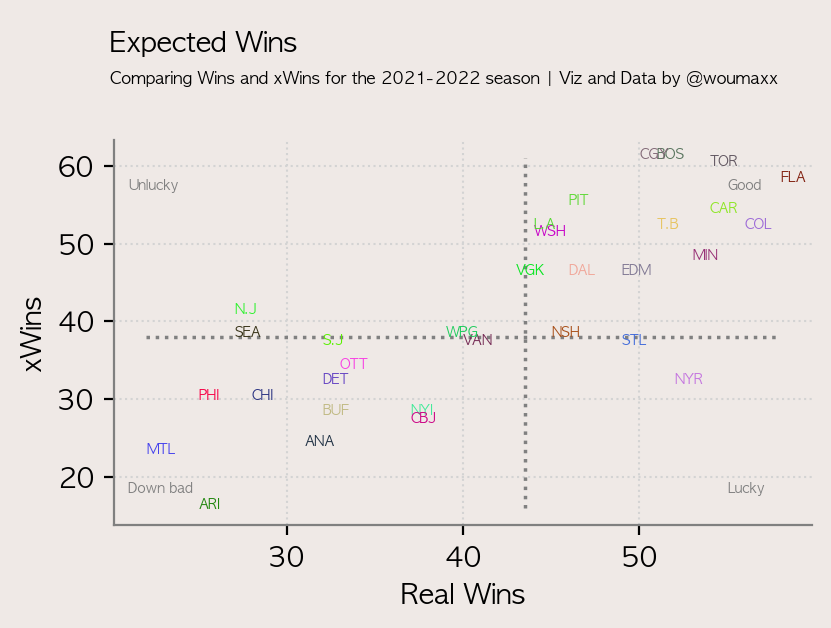

In [48]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig = plt.figure(figsize=(4.5, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

plt.rcParams["font.family"] = "AppleGothic"

# Remove top & right spines and change the color.
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("grey")

# Set the grid
ax.grid(
    visible = True, 
    lw = 0.75,
    ls = ":",
    color = "lightgrey"
)

ax.plot([np.median(stan.W), np.median(stan.W)],
       [stan.xW.min(), stan.xW.max()],
       ls=":",
        lw = 1.25,
    color = "grey",
    #zorder = 4
)

ax.plot([stan.W.min(), stan.W.max()],
        [np.median(stan.xW), np.median(stan.xW)],
       ls=":",
        lw = 1.25,
    color = "grey",
    #zorder = 4
)

ax.text(21, 18, "Down bad", size=5, color="grey")
ax.text(21, 57, "Unlucky", size=5, color="grey")
ax.text(55, 18, "Lucky", size=5, color="grey")
ax.text(55, 57, "Good", size=5, color="grey")



# ax.scatter(stan.W,
#            stan.xW,
#            zorder=2,
#            s=10

# Plot badges
# def getImage(path):
#     return OffsetImage(plt.imread(path), zoom=.011, alpha = 1)

# for index, row in stan.iterrows():
#     ab = AnnotationBbox(getImage(row['logo']), (row['W'], row['xW']), frameon=False)
#     ax.add_artist(ab)


for i in range(len(stan)):
    ax.text(stan.W.iloc[i], stan.xW.iloc[i], stan.Team.iloc[i], size=5, color = f'#{"%06x" % np.random.randint(0, 0xFFFFFF)}')



       

fig_text(
    x = 0.12, y = 1.1,
    s = "Expected Wins",
    color = "black",
    weight = "bold",
    size = 10,
    annotationbbox_kw={"xycoords": "figure fraction"}
)


fig_text(
    x = 0.12, y = 1.02,
    s = "Comparing Wins and xWins for the 2021-2022 season | Viz and Data by @woumaxx\n",
    color = "black",
    size = 6,
    annotationbbox_kw={"xycoords": "figure fraction"}
)

# Set x-axis major tick positions to only 19 game multiples.
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
# Set y-axis major tick positions to only 0.5 xG multiples.
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))


ax.set_ylabel('xWins')
ax.set_xlabel('Real Wins')

#fig.text(0.9, 0.000000001, "\nViz by @woumaxx\ninspired by @sonofacorner", ha="right", size=3, color="grey")
plt.savefig("ANODAVIZ1.png", dpi=600, bbox_inches='tight')
plt.show()

In [9]:
 #print(sorted(list(stan.Team.unique())))


lgs = ["/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/ANA.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/ARZ.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/BOS.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/BUF.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/CAR.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/CBJ.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/CGY.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/CHI.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/COL.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/DAL.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/DET.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/EDM.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/FLO.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/LAK.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/MIN.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/MON.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/NJD.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/NSH.svg.png",
  "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/NYI.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/NYR.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/OTT.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/PHI.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/PIT.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/SJS.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/SEA.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/STL.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/TBL.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/TOR.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/VAN.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/VGK.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/WIN.svg.png",
 "/Users/max/Documents/My Tableau Repository/Shapes/NHL logos/WSH.svg.png"]

TypeError: Image data of dtype <U71 cannot be converted to float

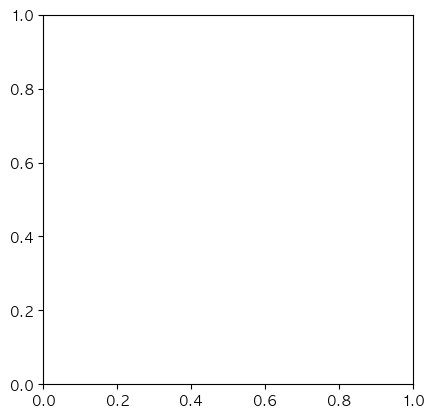

In [96]:
plt.imshow(stan.logo.iloc[1])

In [30]:
stan.sort_values(by="xW", ascending=False).reset_index(drop=True)

,Team,W,xW,logo
0,BOS,51,61,/Users/max/Documents/My Tableau Repository/Sha...
1,CGY,50,61,/Users/max/Documents/My Tableau Repository/Sha...
2,TOR,54,60,/Users/max/Documents/My Tableau Repository/Sha...
3,FLA,58,58,/Users/max/Documents/My Tableau Repository/Sha...
4,PIT,46,55,/Users/max/Documents/My Tableau Repository/Sha...
5,CAR,54,54,/Users/max/Documents/My Tableau Repository/Sha...
6,COL,56,52,/Users/max/Documents/My Tableau Repository/Sha...
7,T.B,51,52,/Users/max/Documents/My Tableau Repository/Sha...
8,L.A,44,52,/Users/max/Documents/My Tableau Repository/Sha...
9,WSH,44,51,/Users/max/Documents/My Tableau Repository/Sha...
